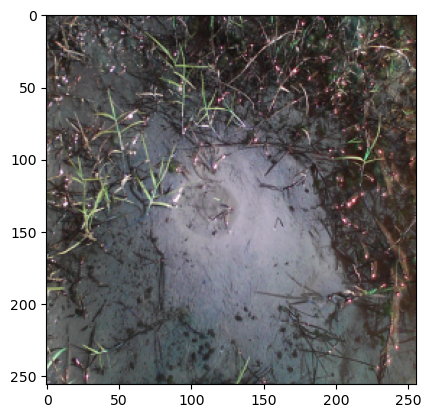

In [1]:
import os
from glob import glob
os.environ["CUDA_VISIBLE_DEVICES"]="1"

%matplotlib inline
from matplotlib import pyplot as plt

from __future__ import print_function
import cv2 as cv
import numpy as np
import argparse
import random as rng
rng.seed(12345)

dim = (256, 256)
src = cv.imread("../datasets/original_dataset/test/images/img_(1).jpg", cv.IMREAD_COLOR)
src = cv.resize(src, dim, interpolation = cv.INTER_AREA)

# Show source image
#cv.imshow('Source Image', src)
plt.imshow(src)
plt.show()
src[np.all(src == 255, axis=2)] = 0

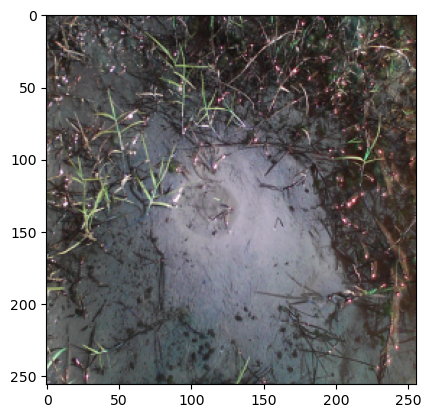

In [2]:
# Show output image
plt.imshow(src)

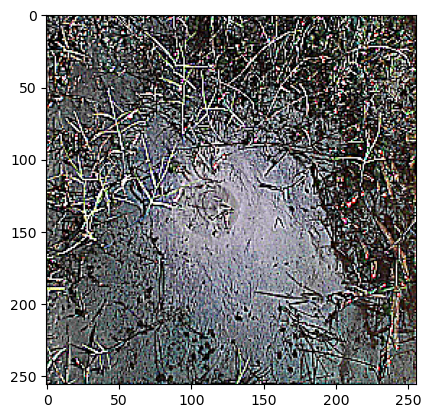

In [3]:
kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]], dtype=np.float32)
# do the laplacian filtering as it is
# well, we need to convert everything in something more deeper then CV_8U
# because the kernel has some negative values,
# and we can expect in general to have a Laplacian image with negative values
# BUT a 8bits unsigned int (the one we are working with) can contain values from 0 to 255
# so the possible negative number will be truncated
imgLaplacian = cv.filter2D(src, cv.CV_32F, kernel)
sharp = np.float32(src)
imgResult = sharp - imgLaplacian
# convert back to 8bits gray scale
imgResult = np.clip(imgResult, 0, 255)
imgResult = imgResult.astype('uint8')
imgLaplacian = np.clip(imgLaplacian, 0, 255)
imgLaplacian = np.uint8(imgLaplacian)
#cv.imshow('Laplace Filtered Image', imgLaplacian)
plt.imshow(imgResult)

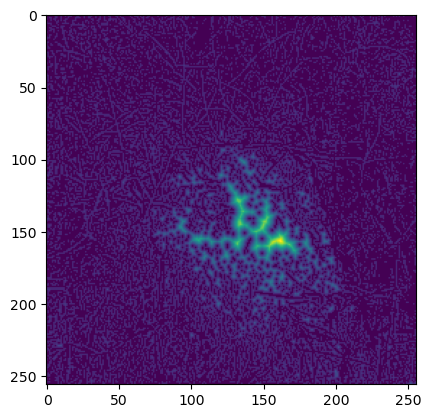

In [4]:
bw = cv.cvtColor(imgResult, cv.COLOR_BGR2GRAY)
_, bw = cv.threshold(bw, 40, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)
plt.imshow(bw)
dist = cv.distanceTransform(bw, cv.DIST_L2, 3)
# Normalize the distance image for range = {0.0, 1.0}
# so we can visualize and threshold it
cv.normalize(dist, dist, 0, 1.0, cv.NORM_MINMAX)
plt.imshow(dist)

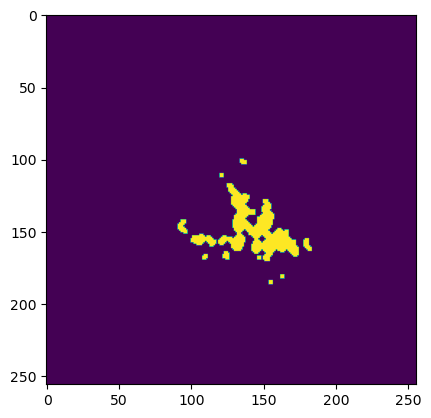

In [5]:
_, dist = cv.threshold(dist, 0.4, 1.0, cv.THRESH_BINARY)
# Dilate a bit the dist image
kernel1 = np.ones((3,3), dtype=np.uint8)
dist = cv.dilate(dist, kernel1)
plt.imshow(dist)
dist_8u = dist.astype('uint8')
# Find total markers
contours, _ = cv.findContours(dist_8u, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
# Create the marker image for the watershed algorithm
markers = np.zeros(dist.shape, dtype=np.int32)

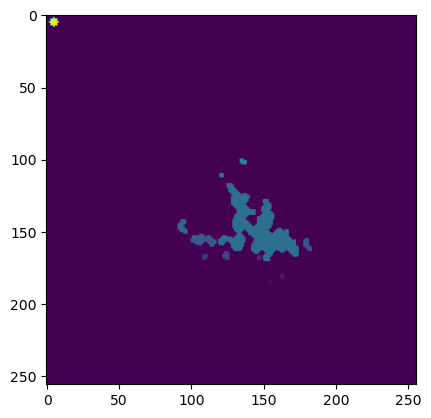

In [6]:
# Draw the foreground markers
for i in range(len(contours)):
    cv.drawContours(markers, contours, i, (i+1), -1)
# Draw the background marker
cv.circle(markers, (5,5), 3, (255,255,255), -1)
markers_8u = (markers * 10).astype('uint8')
plt.imshow(markers_8u)
cv.watershed(imgResult, markers)
#mark = np.zeros(markers.shape, dtype=np.uint8)
mark = markers.astype('uint8')
mark = cv.bitwise_not(mark)
# uncomment this if you want to see how the mark
# image looks like at that point
#plt.imshow(mark)
# Generate random colors
colors = []
for contour in contours:
    colors.append((rng.randint(0,256), rng.randint(0,256), rng.randint(0,256)))
# Create the result image
dst = np.zeros((markers.shape[0], markers.shape[1], 3), dtype=np.uint8)
# Fill labeled objects with random colors
for i in range(markers.shape[0]):
    for j in range(markers.shape[1]):
        index = markers[i,j]
        if index > 0 and index <= len(contours):
            dst[i,j,:] = colors[index-1]

-1

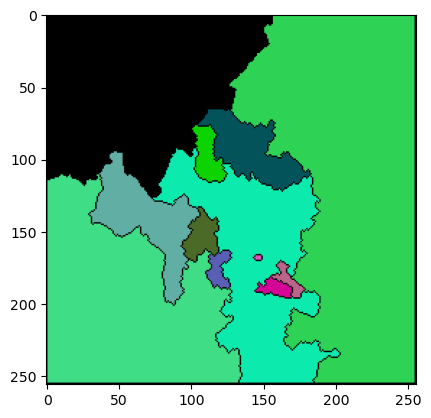

In [ ]:
            
# Visualize the final image
plt.imshow( dst)
cv.waitKey()